In [ ]:
# --- Step 1: Install all necessary libraries ---
!pip install pandas scikit-learn xgboost "transformers>=4.31.0" "torch>=2.0.0" sentence-transformers vaderSentiment

# --- Step 2: Import all necessary tools ---
import pandas as pd
import numpy as np
import joblib
import torch
import xgboost as xgb
from google.colab import drive
from sentence_transformers import SentenceTransformer, util
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

print("✅ All libraries installed and imported successfully.")

✅ All libraries installed and imported successfully.


In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/AIML_Project/amazon.csv'
df = pd.read_csv(file_path)

# Perform robust cleaning - More explicit and handles potential NaNs before conversion
cols_to_clean = {'discounted_price': ['₹', ','], 'actual_price': ['₹', ','], 'rating_count': [','], 'discount_percentage': ['%'], 'rating': ['|']}
for col, chars in cols_to_clean.items():
    if col in df.columns:
        # Ensure column is string type before replace, handle potential NaNs
        df[col] = df[col].astype(str).replace('nan', '')
        for c in chars:
            df[col] = df[col].str.replace(c, '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

essential_columns = list(cols_to_clean.keys()) + ['about_product', 'review_content', 'category']
df_cleaned = df.dropna(subset=essential_columns).copy()

# Engineer 'main_category'
df_cleaned['main_category'] = df_cleaned['category'].apply(lambda s: s.split('|')[-1])
print(f"✅ Data loaded and cleaned. {df_cleaned.shape[0]} rows remaining.")

# --- Engineer all specialist features ---
# AI (Description) Specialist Feature
print("\nLoading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Encoding product descriptions for AI Specialist...")
# Ensure 'about_product' is not empty for encoding
product_descriptions = df_cleaned['about_product'].dropna().tolist()
desc_embeddings = sbert_model.encode(product_descriptions, show_progress_bar=True)
X_ai = pd.DataFrame(desc_embeddings, index=df_cleaned['about_product'].dropna().index)


# Sentiment (Review) Specialist Feature
analyzer = SentimentIntensityAnalyzer()
# Ensure 'review_content' is not empty for sentiment analysis
review_contents = df_cleaned['review_content'].dropna().tolist()
sentiment_scores = [analyzer.polarity_scores(str(r))['compound'] for r in review_contents]
df_cleaned['sentiment_score'] = pd.Series(sentiment_scores, index=df_cleaned['review_content'].dropna().index)


# ML (Market) Specialist Features
category_stats = df_cleaned.groupby('main_category').agg(mean_price=('discounted_price', 'mean'), std_price=('discounted_price', 'std')).reset_index()
df_cleaned = pd.merge(df_cleaned, category_stats, on='main_category', how='left')
df_cleaned['price_zscore'] = (df_cleaned['discounted_price'] - df_cleaned['mean_price']) / df_cleaned['std_price']
df_cleaned['price_zscore'].fillna(0, inplace=True)
numeric_features = ['actual_price', 'discounted_price', 'discount_percentage', 'price_zscore']
categorical_features = ['main_category']
X_ml = df_cleaned[numeric_features + categorical_features]

print("✅ All specialist features created successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data loaded and cleaned. 1462 rows remaining.

Loading SBERT model...
Encoding product descriptions for AI Specialist...


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

✅ All specialist features created successfully.


/tmp/ipython-input-251163341.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['price_zscore'].fillna(0, inplace=True)


In [ ]:
# --- Step 3: Prepare train-test splits for each specialist ---

# The target is the actual star rating
y = df_cleaned['rating']

# AI specialist uses textual description embeddings
X_train_ai, X_test_ai, y_train_ai, y_test_ai = train_test_split(X_ai, y, test_size=0.2, random_state=42)

# ML specialist uses price-related features
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y, test_size=0.2, random_state=42)

print("✅ Data split completed for AI and ML specialists.")

✅ Data split completed for AI and ML specialists.


In [ ]:
# --- Step 4: Train ML Specialist (Market Analyst) ---

from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = ['actual_price', 'discounted_price', 'discount_percentage', 'price_zscore']
categorical_features = ['main_category']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

ml_model = Pipeline([
    ('preprocess', preprocessor),
    ('xgb', XGBRegressor(
        n_estimators=300,
        learning_rate=0.08,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

ml_model.fit(X_train_ml, y_train_ml)
ml_pred = ml_model.predict(X_test_ml)
print(f"ML Specialist MAE: {mean_absolute_error(y_test_ml, ml_pred):.3f}")
print("✅ ML Specialist trained and validated.")

ML Specialist MAE: 0.165
✅ ML Specialist trained and validated.


In [ ]:
# --- Step 5: Train AI Specialist (Description Analyst) ---

ai_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

ai_model.fit(X_train_ai, y_train_ai)
ai_pred = ai_model.predict(X_test_ai)
print(f"AI Specialist MAE: {mean_absolute_error(y_test_ai, ai_pred):.3f}")
print("✅ AI Specialist trained and validated.")

AI Specialist MAE: 0.158
✅ AI Specialist trained and validated.


In [ ]:
# --- Step 6: Evaluate Sentiment Specialist ---
sent_corr = df_cleaned['sentiment_score'].corr(df_cleaned['rating'])
print(f"Sentiment correlation with rating: {sent_corr:.3f}")
print("✅ Sentiment specialist correlation computed (used later as is).")

Sentiment correlation with rating: 0.240
✅ Sentiment specialist correlation computed (used later as is).


In [ ]:
# --- Step 7: Compute Category Archetypes for AI Specialist ---
category_archetypes = {}
for cat in df_cleaned['main_category'].unique():
    cat_descs = df_cleaned[df_cleaned['main_category'] == cat]['about_product'].tolist()
    cat_embedding = sbert_model.encode(cat_descs).mean(axis=0)
    category_archetypes[cat] = cat_embedding

print(f"✅ Computed archetypes for {len(category_archetypes)} categories.")

✅ Computed archetypes for 207 categories.


In [ ]:
# --- Step 7b: Compute Category Review Archetypes ---
review_archetypes = {}
for cat in df_cleaned['main_category'].unique():
    cat_reviews = df_cleaned[df_cleaned['main_category'] == cat]['review_content'].astype(str).tolist()
    if len(cat_reviews) > 0:
        cat_review_emb = sbert_model.encode(cat_reviews).mean(axis=0)
        review_archetypes[cat] = cat_review_emb
    else:
        # fallback to zeros or description archetype if no reviews available
        review_archetypes[cat] = np.zeros_like(list(category_archetypes.values())[0])

joblib.dump(review_archetypes, "category_review_archetypes.pkl")
print(f"✅ Computed and saved review archetypes for {len(review_archetypes)} categories.")

✅ Computed and saved review archetypes for 207 categories.


In [ ]:
# --- Step 8: Derive weights between ML and AI Specialists ---

# Predict on full dataset for correlation calculation
ml_full_pred = ml_model.predict(X_ml)
ai_full_pred = ai_model.predict(X_ai)

corr_ml = abs(np.corrcoef(ml_full_pred, df_cleaned['rating'])[0, 1])
corr_ai = abs(np.corrcoef(ai_full_pred, df_cleaned['rating'])[0, 1])

total_corr = corr_ml + corr_ai
WEIGHT_ML = corr_ml / total_corr
WEIGHT_AI = corr_ai / total_corr

print(f"Data-driven weights:")
print(f"  WEIGHT_ML = {WEIGHT_ML:.3f}")
print(f"  WEIGHT_AI = {WEIGHT_AI:.3f}")

weights = {"WEIGHT_ML": WEIGHT_ML, "WEIGHT_AI": WEIGHT_AI}
joblib.dump(weights, "data_driven_weights.pkl")

print("✅ Saved data-driven weights for app.py usage.")

Data-driven weights:
  WEIGHT_ML = 0.479
  WEIGHT_AI = 0.521
✅ Saved data-driven weights for app.py usage.


In [ ]:
# --- Step 9: Save trained models and preprocessing artifacts ---

joblib.dump(ml_model, "ml_specialist_model.pkl")
joblib.dump(ai_model, "ai_specialist_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(df_cleaned['main_category'].unique().tolist(), "category_list.pkl")
df_cleaned[['main_category', 'mean_price', 'std_price', 'rating']].to_pickle("category_stats.pkl")
joblib.dump(category_archetypes, "category_archetypes.pkl")

print("✅ All trained specialists and assets saved for app integration.")

✅ All trained specialists and assets saved for app integration.


In [ ]:
# --- Step 10: Save all model assets to Google Drive ---

from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the destination folder in your Drive
drive_dir = '/content/drive/My Drive/AIML_Project'
os.makedirs(drive_dir, exist_ok=True)

# List of all model artifact files
files_to_save = [
    "ml_specialist_model.pkl",
    "ai_specialist_model.pkl",
    "preprocessor.pkl",
    "category_list.pkl",
    "category_stats.pkl",
    "category_archetypes.pkl",
    "category_review_archetypes.pkl",
    "data_driven_weights.pkl"
]

# Copy each file to the Drive directory
for file in files_to_save:
    if os.path.exists(file):
        shutil.copy(file, drive_dir)
        print(f"✅ Saved: {file}")
    else:
        print(f"⚠️ File not found: {file}")

print("\n📂 All model assets have been saved to your Drive folder:")
print(drive_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved: ml_specialist_model.pkl
✅ Saved: ai_specialist_model.pkl
✅ Saved: preprocessor.pkl
✅ Saved: category_list.pkl
✅ Saved: category_stats.pkl
✅ Saved: category_archetypes.pkl
✅ Saved: category_review_archetypes.pkl
✅ Saved: data_driven_weights.pkl

📂 All model assets have been saved to your Drive folder:
/content/drive/My Drive/AIML_Project


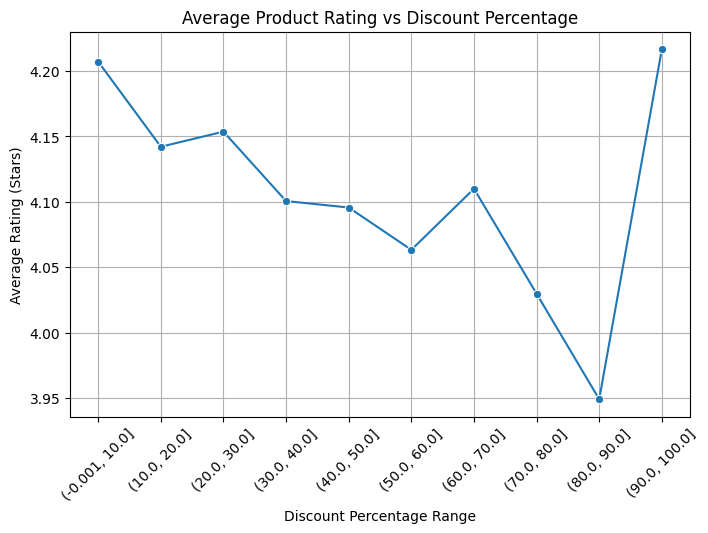

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your cleaned dataset (you already have df_cleaned in the notebook)
# If needed, read again:
# df = pd.read_csv('/content/drive/My Drive/AIML_Project/amazon.csv')
# (repeat your cleaning steps or load df_cleaned directly)

# Step 1: Remove rows with missing/invalid ratings or discounts
df_discount = df_cleaned.dropna(subset=['discount_percentage', 'rating']).copy()
df_discount = df_discount[(df_discount['discount_percentage'] >= 0) & (df_discount['discount_percentage'] <= 100)].copy()

# Step 2: Bin discounts into groups for stability
df_discount['discount_bin'] = pd.cut(df_discount['discount_percentage'],
                                     bins=[0,10,20,30,40,50,60,70,80,90,100],
                                     include_lowest=True)

# Convert the categorical bins to string for plotting compatibility
df_discount['discount_bin'] = df_discount['discount_bin'].astype(str)


# Step 3: Compute average rating per discount bin
discount_summary = df_discount.groupby('discount_bin')['rating'].mean().reset_index()

# Step 4: Plot the relationship
plt.figure(figsize=(8,5))
sns.lineplot(x='discount_bin', y='rating', data=discount_summary, marker='o')
plt.xticks(rotation=45)
plt.title("Average Product Rating vs Discount Percentage")
plt.ylabel("Average Rating (Stars)")
plt.xlabel("Discount Percentage Range")
plt.grid(True)
plt.show()

In [ ]:
from numpy.polynomial.polynomial import polyfit

# Fit a quadratic curve: rating = a + b*(discount) + c*(discount^2)
x = df_discount['discount_percentage']
y = df_discount['rating']
coefs = polyfit(x, y, 2)
print(f"Quadratic coefficients: a={coefs[0]:.4f}, b={coefs[1]:.4f}, c={coefs[2]:.4f}")

# If c > 0 → U-shape; if c < 0 → inverted U-shape


Quadratic coefficients: a=4.2034, b=-0.0025, c=0.0000


In [ ]:
import pandas as pd
from google.colab import drive

# Load and clean the data
try:
    drive.mount('/content/drive')
    file_path = '/content/drive/My Drive/AIML_Project/amazon.csv'
    df = pd.read_csv(file_path)

    # Perform robust cleaning - More explicit and handles potential NaNs before conversion
    cols_to_clean = {'discounted_price': ['₹', ','], 'actual_price': ['₹', ','], 'rating_count': [','], 'discount_percentage': ['%'], 'rating': ['|']}
    for col, chars in cols_to_clean.items():
        if col in df.columns:
            # Ensure column is string type before replace, handle potential NaNs
            df[col] = df[col].astype(str).replace('nan', '')
            for c in chars:
                df[col] = df[col].str.replace(c, '', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')

    essential_columns = list(cols_to_clean.keys()) + ['about_product', 'review_content', 'category']
    df_cleaned = df.dropna(subset=essential_columns).copy()

    # Engineer 'main_category'
    df_cleaned['main_category'] = df_cleaned['category'].apply(lambda s: s.split('|')[-1])

    # Use value_counts() to get the number of products for each unique main category
    category_counts = df_cleaned['main_category'].value_counts()

    # Display the results
    print("\n" + "="*40)
    print(f"Found {len(category_counts)} unique main categories.")
    print("="*40)
    print("\nNumber of items per category:")

    # Print the series containing the counts for each category
    print(category_counts)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please make sure the amazon.csv file is in the correct path in your Google Drive.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Found 207 unique main categories.

Number of items per category:
main_category
USBCables               231
SmartWatches             76
Smartphones              68
SmartTelevisions         63
In-Ear                   52
                       ... 
RotiMakers                1
FanParts&Accessories      1
StandMixers               1
PedestalFans              1
HandheldBags              1
Name: count, Length: 207, dtype: int64


In [ ]:
# Filter categories with 5 or more items
categories_with_5_plus_items = category_counts[category_counts >= 7]

# Display the filtered categories and their counts
print("\n" + "="*40)
print("Categories with 5 or More Items:")
print("="*40)
print(categories_with_5_plus_items)
print(f"\nTotal number of categories with 5 or more items: {len(categories_with_5_plus_items)}")


Categories with 5 or More Items:
main_category
USBCables                      231
SmartWatches                    76
Smartphones                     68
SmartTelevisions                63
In-Ear                          52
RemoteControls                  49
MixerGrinders                   27
Mice                            24
HDMICables                      24
DryIrons                        24
InstantWaterHeaters             23
LintShavers                     22
FanHeaters                      20
ElectricHeaters                 20
HandBlenders                    19
ElectricKettles                 19
WirelessUSBAdapters             18
WallChargers                    16
Lapdesks                        14
MicroSD                         13
LaundryBaskets                  13
Kettle&ToasterSets              13
JuicerMixerGrinders             12
StorageWaterHeaters             12
PowerBanks                      12
SteamIrons                      12
WaterFilters&Purifiers          12
ScreenP

In [ ]:
import joblib
from google.colab import drive
from sentence_transformers import SentenceTransformer, util
import os

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the path to your saved assets
drive_dir = '/content/drive/My Drive/AIML_Project'

# Load the necessary assets
assets = {}
try:
    assets["sbert"] = SentenceTransformer('all-MiniLM-L6-v2') # Load SBERT model directly
    assets["category_archetypes"] = joblib.load(os.path.join(drive_dir, "category_archetypes.pkl"))
    print("✅ Required assets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading asset: {e}. Make sure you have run the previous cells to save the assets.")
    # You might want to handle this error more gracefully in a real application
    raise # Re-raise the exception to stop execution

# --- Diagnose the KeyError ---
print("\n--- Diagnosing KeyError ---")
print("Keys in category_archetypes:")
print(assets["category_archetypes"].keys())
print("\nUnique main categories in df_cleaned:")
print(df_cleaned['main_category'].unique())
print("----------------------------")
# --- End Diagnosis ---


# Now you can use the assets
desc_emb = assets["sbert"].encode(["your description"])
arch_emb = assets["category_archetypes"]["SmartWatches"] # This line might still cause an error if 'SmartWatches' is not a key
similarity_score = util.cos_sim(desc_emb, arch_emb)

print(f"\nDescription Embedding:\n{desc_emb}")
print(f"\nSmartWatches Archetype Embedding:\n{arch_emb}")
print(f"\nCosine Similarity: {similarity_score.item():.4f}")

✅ Required assets loaded successfully.

--- Diagnosing KeyError ---
Keys in category_archetypes:
dict_keys(['USBCables', 'WirelessUSBAdapters', 'HDMICables', 'SmartTelevisions', 'RemoteControls', 'StandardTelevisions', 'TVWall&CeilingMounts', 'RCACables', 'Mounts', 'OpticalCables', 'Projectors', 'Adapters', 'SatelliteReceivers', 'DVICables', 'SpeakerCables', 'StreamingClients', 'AVReceivers&Amplifiers', 'TowerSpeakers', '3DGlasses', 'SmartWatches', 'PowerBanks', 'Smartphones', 'MicroSD', 'BasicMobiles', 'In-Ear', 'AutomobileChargers', 'Cradles', 'WallChargers', 'OTGAdapters', 'Tripods', 'SelfieSticks', 'Stands', 'CableConnectionProtectors', 'Décor', 'ScreenProtectors', 'StylusPens', 'Bedstand&DeskMounts', 'BasicCases', 'HandlebarMounts', 'On-Ear', 'CameraPrivacyCovers', 'PhoneCharms', 'Shower&WallMounts', 'PenDrives', 'Mice', 'GraphicTablets', 'Lapdesks', 'NotebookComputerStands', 'Keyboards', 'Condenser', 'DisposableBatteries', 'GelInkRollerballPens', 'Tape', 'Keyboard&MouseSets', 'Ex

In [ ]:
# ============================================================
# 🔁 Re-center and Normalize Category Archetypes
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sentence_transformers import SentenceTransformer

# Load your cleaned data (replace path if needed)
file_path = '/content/drive/My Drive/AIML_Project/amazon.csv'
df = pd.read_csv(file_path)

# Basic cleaning
df['about_product'] = df['about_product'].fillna('').astype(str)
df['review_content'] = df['review_content'].fillna('').astype(str)
df['main_category'] = df['category'].apply(lambda s: s.split('|')[-1])

# Keep only categories with ≥4 entries (to match your app)
cat_counts = df['main_category'].value_counts()
valid_cats = cat_counts[cat_counts >= 3].index
df = df[df['main_category'].isin(valid_cats)]

print(f"✅ Using {len(valid_cats)} categories with ≥4 entries.")

# Load SBERT
sbert = SentenceTransformer("all-MiniLM-L6-v2")

# --- Description Archetypes ---
category_archetypes = {}
for cat in valid_cats:
    descs = df.loc[df['main_category'] == cat, 'about_product'].tolist()
    emb = sbert.encode(descs, show_progress_bar=True)
    mean_vec = np.mean(emb, axis=0)
    mean_vec = mean_vec / np.linalg.norm(mean_vec)   # normalize
    category_archetypes[cat] = mean_vec

# --- Review Archetypes ---
category_review_archetypes = {}
for cat in valid_cats:
    revs = df.loc[df['main_category'] == cat, 'review_content'].tolist()
    emb = sbert.encode(revs, show_progress_bar=True)
    mean_vec = np.mean(emb, axis=0)
    mean_vec = mean_vec / np.linalg.norm(mean_vec)
    category_review_archetypes[cat] = mean_vec

# --- Save updated files ---
joblib.dump(category_archetypes, "category_archetypes.pkl")
joblib.dump(category_review_archetypes, "category_review_archetypes.pkl")

print("✅ Archetypes re-centered, normalized, and saved successfully!")

✅ Using 75 categories with ≥4 entries.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Archetypes re-centered, normalized, and saved successfully!


In [ ]:
# --- Step 10: Save all model assets to Google Drive ---

from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the destination folder in your Drive
drive_dir = '/content/drive/My Drive/AIML_Project'
os.makedirs(drive_dir, exist_ok=True)

# List of all model artifact files
files_to_save = [
    "ml_specialist_model.pkl",
    "ai_specialist_model.pkl",
    "preprocessor.pkl",
    "category_list.pkl",
    "category_stats.pkl",
    "category_archetypes.pkl",
    "category_review_archetypes.pkl",
    "data_driven_weights.pkl"
]

# Copy each file to the Drive directory
for file in files_to_save:
    if os.path.exists(file):
        shutil.copy(file, drive_dir)
        print(f"✅ Saved: {file}")
    else:
        print(f"⚠️ File not found: {file}")

print("\n📂 All model assets have been saved to your Drive folder:")
print(drive_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚠️ File not found: ml_specialist_model.pkl
⚠️ File not found: ai_specialist_model.pkl
⚠️ File not found: preprocessor.pkl
⚠️ File not found: category_list.pkl
⚠️ File not found: category_stats.pkl
✅ Saved: category_archetypes.pkl
✅ Saved: category_review_archetypes.pkl
⚠️ File not found: data_driven_weights.pkl

📂 All model assets have been saved to your Drive folder:
/content/drive/My Drive/AIML_Project


In [ ]:
from sentence_transformers import util
emb = sbert.encode(["1.83″ display (240×280) with Bluetooth calling and AI voice assistant. Tracks SpO₂..."])
sim = util.cos_sim(emb, category_archetypes["SmartWatches"])
print("Similarity:", sim.item())

Similarity: 0.4797540307044983


In [ ]:
import joblib, numpy as np

cats = joblib.load("category_archetypes.pkl")
for k,v in cats.items():
    cats[k] = v / np.linalg.norm(v)
joblib.dump(cats, "category_archetypes.pkl")

['category_archetypes.pkl']

In [ ]:
from statistics import mean
import numpy as np

# Collect typical scale ranges from a few samples
def analyze_scales():
    out = []
    for cat in assets["category_archetypes"].keys():
        # 20 random descriptions per category
        descs = df[df.main_category==cat].sample(min(20,len(df[df.main_category==cat]))).about_product
        embs = assets["sbert"].encode(descs.tolist())
        sims = [float(util.cos_sim(e, assets["category_archetypes"][cat])) for e in embs]
        out.extend(sims)
    print("Average archetype similarity:", round(mean(out),3))
    print("Min:", round(min(out),3), "Max:", round(max(out),3))
analyze_scales()

Average archetype similarity: 0.771
Min: 0.187 Max: 0.998
